<h1 style="white-space: nowrap" align="center">Mini-Project 1</h1>
<hr style="clear:both"></hr>

In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

Gtk-Message: 18:02:11.339: Failed to load module "canberra-gtk-module"


In [2]:
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()


(ipykernel_launcher.py:455): Gtk-CRITICAL **: 18:02:22.599: gtk_window_resize: assertion 'height > 0' failed


In [3]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')
        
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data

<h2>DOWNLOAD OF FILES</h2>

In [4]:
dataset_id = 'ds000171'
subject = 'control01' 

sample_path = "/home/jovyan/Data/dataset"

mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

subject_dir = 'sub-{}'.format(subject)

In [5]:
###################
# Openneuro download.
###################
subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, # Openneuro has for each dataset a unique identifier
                "--target-dir", bids_root,  # The path where we want to save our data. You should save your data under /home/jovyan/Data/[your dataset ID] to be 100% fool-proof
                "--include", op.join(subject_dir, '*'),# We are asking to get all files within the subject_dirt folder by using the wildcard *
               ], check=True)

###################
# Create folders relevant for preprocessing.
# In BIDs, ANYTHING we modify must go in the derivatives folder, to keep original files clean in case we make a mistake.
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-control01'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'func'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'fmap'))


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds000171 …


📁 Traversing directories for ds000171 : 436 entities [00:31, 14.01 entities/s]


📥 Retrieving up to 15 files (5 concurrent downloads). 


sub-control01_T1w.nii.gz:   0%|          | 0.00/8.77M [00:00<?, ?B/s]
CHANGES:   0%|          | 0.00/45.0 [00:00<?, ?B/s]
                                                   
README:   0%|          | 0.00/0.98k [00:00<?, ?B/s]
sub-control01_T1w.nii.gz:   0%|          | 32.6k/8.77M [00:00<00:27, 329kB/s]
dataset_description.json:   0%|          | 0.00/2.79k [00:00<?, ?B/s]
                                                                     
participants.tsv:   0%|          | 0.00/1.63k [00:00<?, ?B/s]
sub-control01_T1w.nii.gz:   1%|▏         | 118k/8.77M [00:00<00:20, 436kB/s] 
sub-control01_task-music_run-1_events.tsv: 0.00B [00:00, ?B/s]
sub-control01_T1w.nii.gz:   2%|▏         | 186k/8.77M [00:00<00:22, 407kB/s]
sub-control01_task-music_run-3_bold.nii.gz:   0%|          | 0.00/33.9M [00:00<?, ?B/s]

sub-control01_task-music_run-1_bold.nii.gz:   0%|          | 0.00/33.8M [00:00<?, ?B/s]


sub-control01_task-music_run-2_events.tsv:   0%|          | 0.00/339 [00:00<?, ?B/s]


sub-contro

✅ Finished downloading ds000171.
 
🧠 Please enjoy your brains.
 


<h3>Function used to clear the directory in case the process compromises the data and we need to download everything again :</h3>

In [6]:
def clear_data(basis = True, deriv = True, anat = True, func = True, mask = False):
    if basis:
        os.remove(op.join(bids_root, 'README'))
        os.remove(op.join(bids_root, 'CHANGES'))
        os.remove(op.join(bids_root, 'participants.tsv'))
        os.remove(op.join(bids_root, 'dataset_description.json'))
    if mask:
        os.remove(op.join(bids_root, 'derivatives', 'preprocessed_data', 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz'))
        os.remove(op.join(bids_root, 'derivatives', 'preprocessed_data', 'sub-control01', 'anat', 'sub-control01_T1w_mask.nii.gz'))
    if deriv:
        os.rmdir(op.join(bids_root, 'derivatives', 'preprocessed_data', 'sub-control01', 'anat'))
        os.rmdir(op.join(bids_root, 'derivatives', 'preprocessed_data', 'sub-control01', 'fmap'))
        os.rmdir(op.join(bids_root, 'derivatives', 'preprocessed_data', 'sub-control01', 'func'))
    if anat:
        os.remove(op.join(bids_root, 'sub-control01','anat', 'sub-control01_T1w.nii.gz'))
        os.rmdir(op.join(bids_root, 'sub-control01', 'anat'))
    if func:
        os.remove(op.join(bids_root,'sub-control01','func', 'sub-control01_task-music_run-1_bold.nii.gz'))
        os.remove(op.join(bids_root, 'sub-control01','func', 'sub-control01_task-music_run-2_bold.nii.gz'))
        os.remove(op.join(bids_root,'sub-control01','func', 'sub-control01_task-music_run-3_bold.nii.gz'))
        os.remove(op.join(bids_root,  'sub-control01','func', 'sub-control01_task-nonmusic_run-4_bold.nii.gz'))
        os.remove(op.join(bids_root, 'sub-control01','func', 'sub-control01_task-nonmusic_run-5_bold.nii.gz'))
        os.remove(op.join(bids_root,  'sub-control01','func', 'sub-control01_task-music_run-1_events.tsv'))
        os.remove(op.join(bids_root, 'sub-control01','func', 'sub-control01_task-music_run-2_events.tsv'))
        os.remove(op.join(bids_root, 'sub-control01','func', 'sub-control01_task-music_run-3_events.tsv'))
        os.remove(op.join(bids_root,'sub-control01','func', 'sub-control01_task-nonmusic_run-4_events.tsv'))
        os.remove(op.join(bids_root, 'sub-control01','func', 'sub-control01_task-nonmusic_run-5_events.tsv'))
        os.rmdir(op.join(bids_root, 'sub-control01','func'))
    os.rmdir(op.join(bids_root, 'sub-control01'))
    os.rmdir(op.join(bids_root, 'derivatives', 'preprocessed_data', 'sub-001'))
    os.rmdir(op.join(bids_root, 'derivatives', 'preprocessed_data'))
    os.rmdir(op.join(bids_root, 'derivatives'))

In [7]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|------------ fmap/
|------------ func/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-4_events.tsv
|--------- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-5_events.tsv


In [8]:
patient_path = op.join(bids_root, 'sub-control01')
anatomical_path = op.join(patient_path, 'anat')
anatomical_file = op.join(anatomical_path, 'sub-control01_T1w.nii.gz')
functional_path = op.join(patient_path, 'func')

<h2>Skull Stripping (Here robust method is used)</h2>

In [10]:
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------result
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    subject = 'sub-{}'.format(subject_id)
    anat_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w.nii.gz'.format(subject_id))
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anat_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask')
get_skull_stripped_anatomical(bids_root, preproc_root, "control01", True)
resulting_treated_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz')

Done with BET.


In [11]:
## TO VERIFY IF MASK WAS PRO1PERLY GENERATED
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|------------ fmap/
|------------ func/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-4_events.tsv
|--------- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-5_events.tsv


In [12]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(anatomical_file)
fsleyesDisplay.load(resulting_mask_path)


(ipykernel_launcher.py:455): Gdk-WARNING **: 18:04:45.280: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [13]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(resulting_treated_path)

In [14]:
def fsl_mask(img_path, mask_path, masked_img_path):
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))

In [16]:
## IN CASE YOU WANT TO EDIT THE MASK THAT WAS GENERATED BY BET FEEL FREE TO SKIP IT ROBUST ALGORITHM SEEMS TO WORK PRETTY WELL
fsl_mask(anatomical_file, resulting_mask_path, resulting_treated_path)

In [14]:
functional_first_path = op.join(functional_path, 'sub-control01_task-music_run-1_bold.nii.gz')

In [15]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(functional_path, 'sub-control01_task-music_run-1_bold.nii.gz'))

<h3>Use of FLIRT for alignment and organization of views</h3>

In [16]:
from fsl.wrappers import flirt
subject_id = 'control01'
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))
target = resulting_treated_path
reference = mni_template
result = op.join(preproc_root, 'sub-{}'.format(subject_id), 'anat', 'sub-{}_T1w_mni'.format(subject_id))
flirt(target, reference, out=result)


Final result: 
0.003348 0.005721 -1.116064 204.794610 
-0.933350 0.500887 0.005750 178.784833 
0.501418 1.048657 -0.003251 -149.700516 
0.000000 0.000000 0.000000 1.000000 



{}

In [17]:
## VERIFY IF THE PROCESS HAPPENED CORRECTLY
processed_volume = result
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(processed_volume)

<h2>Normalization of the data</h2>

In [18]:
import matplotlib.pyplot as plt
import nibabel as nib
processed_functional_path = op.join(preproc_root, 'sub-control01', 'func')

In [19]:
def normalize_fMRI(source, output, threshold):
    img = nib.load(source)
    data = img.get_fdata()
    mask = data>=threshold
    masked_data = data[mask]
    mean = masked_data.mean()
    std = masked_data.std()
    normalized = (data - mean)/std
    img_out = nib.Nifti1Image(normalized,img.affine, img.header)
    nib.save(img_out, output)

<h3>Correction of slice 17 in second run</h3>

In [20]:
path_normalized_output_1 = op.join(processed_functional_path, 'sub-control01_task-music_run-1_bold_norm.nii.gz')
path_normalized_output_2 = op.join(processed_functional_path, 'sub-control01_task-music_run-2_bold_norm_.nii.gz')
path_normalized_output_3 = op.join(processed_functional_path, 'sub-control01_task-music_run-3_bold_norm_.nii.gz')
functional_2_path = op.join(functional_path, 'sub-control01_task-music_run-2_bold.nii.gz')
functional_3_path = op.join(functional_path, 'sub-control01_task-music_run-3_bold.nii.gz')

In [21]:
img = nib.load(functional_2_path)
data = img.get_fdata()
data[:, :, 47, 17] = np.mean(data[:, :, 46, 17])
img_out = nib.Nifti1Image(data,img.affine, img.header)
nib.save(img_out, functional_2_path)

In [22]:
normalize_fMRI(functional_first_path, path_normalized_output_1, 200)
normalize_fMRI(functional_2_path, path_normalized_output_2, 200)
normalize_fMRI(functional_3_path, path_normalized_output_3, 200)

In [23]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|--------------- sub-control01_T1w_mni.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-control01_task-music_run-1_bold_norm.nii.gz
|--------------- sub-control01_task-music_run-2_bold_norm_.nii.gz
|--------------- sub-control01_task-music_run-3_bold_norm_.nii.gz
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4

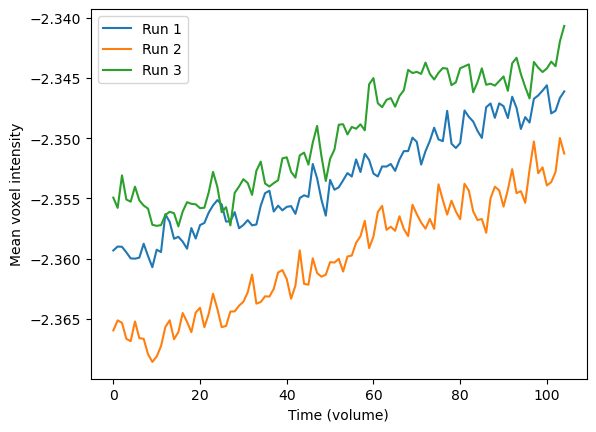

In [24]:
plt.plot(nib.load(path_normalized_output_1).get_fdata().mean(axis=(0,1,2)), label='Run 1')
plt.plot(nib.load(path_normalized_output_2).get_fdata().mean(axis=(0,1,2)), label='Run 2')
plt.plot(nib.load(path_normalized_output_3).get_fdata().mean(axis=(0,1,2)), label='Run 3')
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')
plt.legend()
plt.show()

In [25]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(functional_2_path)

<h2>Concatenation of data</h2>

In [26]:
img_1 = nib.load(path_normalized_output_1)
data_1 = img_1.get_fdata()
img_2 = nib.load(path_normalized_output_2)
data_2 = img_2.get_fdata()
img_3 = nib.load(path_normalized_output_3)
data_3 = img_3.get_fdata()

In [29]:
data = np.concatenate((data_1, data_2, data_3), axis = 3)

In [30]:
functional_concatenated= op.join(functional_path, 'sub-control01_task-music_concat_bold.nii.gz')

In [31]:
img_out = nib.Nifti1Image(data,img_1.affine, img_1.header)
nib.save(img_out, functional_concatenated)

In [32]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(functional_concatenated)

<h2>Movement correction of motion corrected fMRI using MCFLIRT</h2>

In [34]:
outpath = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_bold_moco')

In [35]:
from fsl.wrappers import mcflirt
mcflirt(infile=functional_concatenated,o=outpath, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][2

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

{}

In [37]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(outpath)